In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, chi2_contingency
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

Data and Notebook Setup

In [2]:
shipData = pd.read_csv(r"C:\Users\Brandon Nordell\Desktop\CHR Project\IMA Recommendation Simulation Data.csv")
shipData = shipData.drop(shipData.columns[[0]], axis=1) #drop extra row labels

shipData

,request_id,week_id,weekday,miles,order_equipment_type,order_distance,order_num_stops,order_origin_weight,lead_days,color,origin_dat_ref,dest_dat_ref,rate_norm,est_cost_norm,CurrentCondition
0,c2653eda11cd4d94879d1946392eb2b5,4,Sat,1856,V,1848.0,2,40000.0,3,RED,633,978,2.273442,2.138631,Accepted
1,65e3dcc84a2246e68ea8636a967b31b2,3,Mon,56,V,47.0,2,12729.0,3,RED,604,604,-0.971030,-1.017024,Rejected
2,0a86f005640a4204b46c95ca033a7ced,1,Fri,259,V,255.0,2,44176.0,3,RED,761,770,-0.393352,-0.475805,Accepted
3,1105b4bc7b444f7985d4ad810e7acbc2,3,Thu,71,V,68.0,2,39847.0,6,RED,187,180,-0.706546,-0.765855,Rejected
4,de538100bb0f4137961b9551640ef35e,3,Fri,1182,R,1183.0,2,34912.0,3,GREEN,972,922,1.014233,0.469273,Accepted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161558,a15fa8bdb9924162999c502997b80ad2,4,Thu,274,V,0.0,2,44084.0,1,GREEN,170,119,0.791117,-0.045967,Accepted
161559,151354fa712049f1a6d1644ec17878f9,4,Tue,213,V,201.0,2,43500.0,7,YELLOW,57,132,-0.189311,-0.223419,Rejected
161560,fa71111ad30d492683f9a6a5fbc9f07e,4,Tue,300,V,308.0,2,43500.0,3,GREEN,551,527,-0.709962,-0.658659,Accepted
161561,22de0c744a4741c2a1f14bf4a520a3c0,4,Wed,2209,V,2213.0,2,8280.0,12,GREEN,490,945,2.681378,1.530088,Accepted


a. Shape: 161563 rows × 15 columns

In [3]:
categoryList = [] #list to hold all unique categorys to be counted
for i in range(0, len(shipData['CurrentCondition'])):
    if shipData['CurrentCondition'][i] not in categoryList and shipData['CurrentCondition'][i] != '': 
        categoryList.append(shipData['CurrentCondition'][i])
  
categoryList.pop(5) #remove blank category as an option since there is no data in the cell, not a category
print("Num unique categories: ", len(categoryList))
  
print("Unique Categories: ", categoryList)

Num unique categories:  7
Unique Categories:  ['Accepted', 'Rejected', 'Withdrawn', 'Waiting On Acceptance', 'Cancelled', 'Waiting On Recommendation', 'NoPace']


b. 
There are 7 unique categories for CurrentCondition: Accepted, Rejected, Withdrawn, Waiting on Acceptance, Waiting on Recommendation, Cancelled, and NoPace

Exploratory Data Analysis

In [4]:
len(shipData['request_id'].unique()) #counts the amount of unique IDs in the set

161562

a. request_id is not unique, as there are 161562 unique IDs out of a set of 161563 IDs, so there is a row with a duplicate ID somewhere in the table

In [5]:
len(shipData.columns)
nullCheck = []
for i in range(0, len(shipData.columns)): #look through each column
    for j in range (0, 161563): #look through each of the cells in the column until we hit an empty cell
        if pd.isna(shipData.iloc[:,i][j]): #if we hit an empty cell
            nullCheck.append(shipData.columns[i]) #add the name of the column where we found the empty cell to the results array
            break #go to the next column, since we know that the current column has at least one empty cell
        
print(nullCheck)

['order_distance', 'order_origin_weight', 'rate_norm', 'est_cost_norm', 'CurrentCondition']


b. Cols that contain missing data: order_distance, order_origin_weight, rate_norm, est_cost_norm, CurrentCondition

Pearson's correlation:  0.9822910020621143


Text(0, 0.5, 'order_distance')

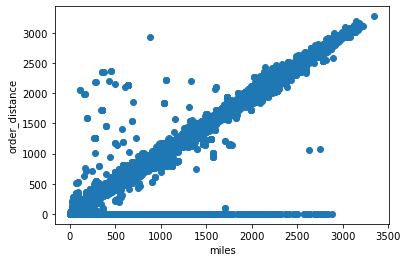

In [6]:
shipData.dropna(subset=['order_distance'], inplace=True)

mcorr, _ = pearsonr(shipData['miles'], shipData['order_distance'])
print("Pearson's correlation: ", mcorr) #1 is fully correlated

plt.scatter(shipData['miles'], shipData['order_distance'])
plt.xlabel("miles")
plt.ylabel("order_distance")


In [7]:
#reset data
shipData = pd.read_csv(r"C:\Users\Brandon Nordell\Desktop\CHR Project\IMA Recommendation Simulation Data.csv")
shipData = shipData.drop(shipData.columns[[0]], axis=1) #drop extra row labels

In [8]:
shipData.dropna(subset=['CurrentCondition'], inplace=True) #look at the data we fully have

compCT = pd.crosstab(index=shipData['color'],columns=shipData['CurrentCondition'])
compCT

CurrentCondition,Accepted,Cancelled,NoPace,Rejected,Waiting On Acceptance,Waiting On Recommendation,Withdrawn
color,,,,,,,
GREEN,41312,604,7,1353,7,10,4118
RED,40964,2503,47,33116,721,82,17043
YELLOW,13889,281,0,2674,72,3,2639


In [9]:
ChiSqRes = chi2_contingency(compCT)

#for this test, our null (H0) is that color and Current Condition are not correlated. If the p-value for this test comes out
#greater than 0.05, we will reject the null, and determine that color and CurrentCondition are in fact related
print("p-Val for correlation: ", ChiSqRes[1])

p-Val for correlation:  0.0


c. The two pairs that in my opinion could be considered highly correlated are miles and order_distance, as well as color and CurrentCondition. I picked these two pairs because they seem to roughly measure the same thing. 

In the case of the first pair, the distance between origin and destination, as well as the miles that the customer believes the truck will drive are likely to be very similar. The Pearson's correlation value shows this, with a value of .9823. This indicates an incredibly strong correlation between the two characteristics. Likewise, in the graph, there is a very distinct linear pattern that the data shows (apart from a few outliers, where the order distance ended up being 0). 

For the second pair, both characteristics reflect the order status of an order, CurrentCondition providing a more detailed description of the status versus a scale of three colors that color offers. After conducting a Chi-Squared test on the colors and CurrentConditions, the p-value produced from this test was either 0 or very close to 0 (to the point where the python function just returned 0.0). The implied null hypothesis of the test was that the two characteristics are not correlated. However, since the p-value was less than 0.05 (0.0), we reject this null hypothesis for the idea that the two characteristics are in fact correlated. This correlation is also seen in the crosstab above, if not obviously. For the GREEN color, the grand majority of the orders were accepted. For RED, while a large chunk were accepted, another large chunk were rejected or withdrawn (the sum of those two being greater than the amount of accepted orders). There also were more cancelled orders than GREEN and YELLOW combined. YELLOW presented as a mix between the two, having mostly accepted ordersm but also a few waiting on acceptance, and a small amount being withdrawn as well.

In [10]:
#reset data
shipData = pd.read_csv(r"C:\Users\Brandon Nordell\Desktop\CHR Project\IMA Recommendation Simulation Data.csv")
shipData = shipData.drop(shipData.columns[[0]], axis=1) #drop extra row labels

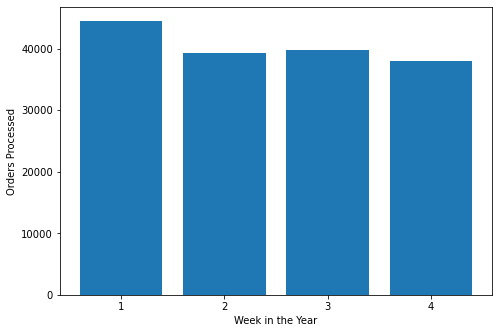

In [11]:
orders = [0, 0, 0, 0]
for i in range(0, len(shipData.index)): #count the amount of orders that occur over each week
    orders[(shipData['week_id'][i])-1] += 1 #the -1 will adjust for array indices

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([1, 2, 3, 4],orders)
ax.set_xticks([1, 2, 3, 4])
ax.set_xlabel('Week in the Year')
ax.set_ylabel('Orders Processed')
plt.show()

di. No real notable connection between week of the year and orders processed. Having a full year's worth of data could paint a better, more clear picture of a connection, whether that would involve showing the relation of the week of the month over the entire year, or just the trend across the entire year.

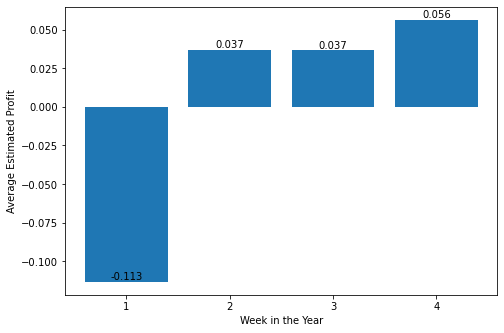

In [12]:
shipData.dropna(subset=['rate_norm'], inplace=True)
shipData.dropna(subset=['est_cost_norm'], inplace=True)

shipData['estProfit'] = shipData['rate_norm'] - shipData['est_cost_norm']
shipData = shipData.reset_index(drop = True)
week1Prof = 0
week1Ct = 0
week2Prof = 0
week2Ct = 0
week3Prof = 0
week3Ct = 0
week4Prof = 0
week4Ct = 0

for i in range(0, len(shipData.index)): #count the amount of orders that occur over each week, as well as the profit of each week
    if shipData['week_id'][i] == 1:
        week1Ct += 1 #increase the count of data points from week 1
        week1Prof += shipData['estProfit'][i] #add to the combined week 1 profits
    elif shipData['week_id'][i] == 2:
        week2Ct += 1
        week2Prof += shipData['estProfit'][i]
    elif shipData['week_id'][i] == 3:
        week3Ct += 1
        week3Prof += shipData['estProfit'][i]
    elif shipData['week_id'][i] == 4:
        week4Ct += 1
        week4Prof += shipData['estProfit'][i]
        
#get the average weekly estimated profits for each week
avgEstWeeklyProfits = [week1Prof/week1Ct, week2Prof/week2Ct, week3Prof/week3Ct, week4Prof/week4Ct]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bars = ax.bar([1, 2, 3, 4],avgEstWeeklyProfits)
ax.set_xticks([1, 2, 3, 4])
ax.set_xlabel('Week in the Year')
ax.set_ylabel('Average Estimated Profit')

#credit to https://towardsdatascience.com/how-to-make-bar-and-hbar-charts-with-labels-using-matplotlib-b701ce70ba9c#9082
#for the following chunk
for bar in bars: 
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax.text(label_x_pos, height, s=f'{round(height, 3)}', ha='center',
  va='bottom')
plt.show()

dii. Orders in the first week of the year tend to return a negative normalized profit on average, while orders in weeks 2-4 tend to return a slight positive normalized profit. Would be interesting to look at the first week of each month over a year (or even better, several years) to get a better idea of the trends of monthly normalized profit.

Classification Modeling

In [13]:
#reset and prep data for classification modeling
shipData = pd.read_csv(r"C:\Users\Brandon Nordell\Desktop\CHR Project\IMA Recommendation Simulation Data.csv")
shipData = shipData.drop(shipData.columns[[0]], axis=1) #drop extra row labels, ID is also not going to matter for classification
#also drop origin and destination, these create a massive data frame, and have the potential to not affect the models
#they can be added in future iterations if the time/desire is there
shipData = shipData.drop(['request_id', 'origin_dat_ref', 'dest_dat_ref'], axis = 1)

#drop rows with empty cells, data loss of about 3% of set
shipData.dropna(subset=['order_distance', 'order_origin_weight', 'rate_norm', 'est_cost_norm', 'CurrentCondition'], inplace=True)
shipData = shipData.reset_index(drop = True)

#one-hot encoding for dummy variables
shipData = pd.get_dummies(shipData, columns = ['week_id', 'weekday', 'order_equipment_type', 'order_num_stops', 'color'])

#move CurrentCondition to the end of the DataFrame for easier pre-split manipulation
cc = shipData.pop('CurrentCondition')
shipData['CurrentCondition'] = cc

shipData

,miles,order_distance,order_origin_weight,lead_days,rate_norm,est_cost_norm,week_id_1,week_id_2,week_id_3,week_id_4,...,weekday_Thu,weekday_Tue,weekday_Wed,order_equipment_type_R,order_equipment_type_V,order_num_stops_2,color_GREEN,color_RED,color_YELLOW,CurrentCondition
0,1856,1848.0,40000.0,3,2.273442,2.138631,0,0,0,1,...,0,0,0,0,1,1,0,1,0,Accepted
1,56,47.0,12729.0,3,-0.971030,-1.017024,0,0,1,0,...,0,0,0,0,1,1,0,1,0,Rejected
2,259,255.0,44176.0,3,-0.393352,-0.475805,1,0,0,0,...,0,0,0,0,1,1,0,1,0,Accepted
3,71,68.0,39847.0,6,-0.706546,-0.765855,0,0,1,0,...,1,0,0,0,1,1,0,1,0,Rejected
4,1182,1183.0,34912.0,3,1.014233,0.469273,0,0,1,0,...,0,0,0,1,0,1,1,0,0,Accepted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156564,274,0.0,44084.0,1,0.791117,-0.045967,0,0,0,1,...,1,0,0,0,1,1,1,0,0,Accepted
156565,213,201.0,43500.0,7,-0.189311,-0.223419,0,0,0,1,...,0,1,0,0,1,1,0,0,1,Rejected
156566,300,308.0,43500.0,3,-0.709962,-0.658659,0,0,0,1,...,0,1,0,0,1,1,1,0,0,Accepted
156567,2209,2213.0,8280.0,12,2.681378,1.530088,0,0,0,1,...,0,0,1,0,1,1,1,0,0,Accepted


In [14]:
#For the sake of this project/assignment, we will use full dataset for the model
#If this was a full-blown project, after we would get these results, we could look at potential overfitting or other variables
#that could be removed to try and produce a more optimal solution than what this first iteration would spit out

#get data for features of model
X = shipData.iloc[:,:-1].values
#get target data 
y = shipData['CurrentCondition']

#80/20 train/test, seed added for future repeatability if desired
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=26) 

In [36]:
#We'll use two different types of models: Gaussian Naive Bayes and a Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
clf=RandomForestClassifier(n_estimators=100)
nb = GaussianNB()

clf.fit(X_train,y_train)
nb.fit(X_train, y_train)

GaussianNB()

In [37]:
rfPred = clf.predict(X_test)
nbPred = nb.predict(X_test)

In [70]:
# Accuracy score is the simplest way to evaluate
print("Random Forest Accuracy %: ", accuracy_score(rfPred, y_test))
print("Naive Bayes Accuracy %: ", accuracy_score(knnPred, y_test), "\n")

#get LogLoss to show confidence of classifiers
from sklearn.metrics import log_loss
clf_probs = clf.predict_proba(X_test)
clf_score = log_loss(y_test, clf_probs)
print("Random Forest LogLoss: ", clf_score)

nb_probs = nb.predict_proba(X_test)
nb_score = log_loss(y_test, nb_probs)
print("Naive Bayes LogLoss: ", nb_score, "\n")

# But Confusion Matrix and Classification Report give more details about performance
print("Random Forest Class Report: \n", classification_report(rfPred, y_test))
print("Naive Bayes Class Report: \n", classification_report(knnPred, y_test))

Random Forest Accuracy %:  0.7478763492367632
Naive Bayes Accuracy %:  0.6409912499201635 

Random Forest LogLoss:  0.8519564207986047
Naive Bayes LogLoss:  1.2780761810000005 

Random Forest Class Report: 
                            precision    recall  f1-score   support

                 Accepted       0.90      0.78      0.83     21520
                Cancelled       0.29      0.67      0.40       287
                   NoPace       0.33      1.00      0.50         3
                 Rejected       0.63      0.67      0.65      6623
    Waiting On Acceptance       0.29      0.74      0.41        57
Waiting On Recommendation       0.00      0.00      0.00         5
                Withdrawn       0.42      0.70      0.52      2819

                 accuracy                           0.75     31314
                macro avg       0.41      0.65      0.47     31314
             weighted avg       0.79      0.75      0.76     31314



E:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes Class Report: 
                            precision    recall  f1-score   support

                 Accepted       0.86      0.69      0.76     23346
                Cancelled       0.15      0.42      0.22       239
                   NoPace       0.00      0.00      0.00         0
                 Rejected       0.36      0.52      0.43      4976
    Waiting On Acceptance       0.18      0.43      0.25        60
Waiting On Recommendation       0.00      0.00      0.00         0
                Withdrawn       0.28      0.49      0.35      2693

                 accuracy                           0.64     31314
                macro avg       0.26      0.36      0.29     31314
             weighted avg       0.72      0.64      0.67     31314



E:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4a. The classifier that appears to perform better is the random forest classifier. Not only at first glance does it have a better overall accuracy, its precision and recall throughout all of the different predicted CurrentConditions are greater than in the Gaussian Naive Bayes. It also has a greater confidence in its classifications, due to its smaller LogLoss value. The precisions of the models presents the RF model as containing more true positives than the GNB. 

In [39]:
#Random Forest importances
importance = clf.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.13251
Feature: 1, Score: 0.13063
Feature: 2, Score: 0.15595
Feature: 3, Score: 0.09142
Feature: 4, Score: 0.13919
Feature: 5, Score: 0.15533
Feature: 6, Score: 0.00714
Feature: 7, Score: 0.00764
Feature: 8, Score: 0.00719
Feature: 9, Score: 0.00748
Feature: 10, Score: 0.01000
Feature: 11, Score: 0.01017
Feature: 12, Score: 0.00196
Feature: 13, Score: 0.00136
Feature: 14, Score: 0.01004
Feature: 15, Score: 0.00990
Feature: 16, Score: 0.01006
Feature: 17, Score: 0.00333
Feature: 18, Score: 0.00342
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.04832
Feature: 21, Score: 0.04992
Feature: 22, Score: 0.00703


bi: The five primary features that present as important in the RF model are as follows: miles, order_distance, order_origin_weight, rate_norm, est_cost_norm

In [52]:
#Naive Bayes Importances
from sklearn.inspection import permutation_importance
imps = permutation_importance(nb, X_test, y_test)
importances = imps.importances_mean
for i in range(0, len(importances)):
    print("Feature: ", i, ": ", importances[i])

Feature:  0 :  0.0042920099635945785
Feature:  1 :  0.004566647505907917
Feature:  2 :  0.00470077281727026
Feature:  3 :  0.00692342083413171
Feature:  4 :  0.0011113240084307697
Feature:  5 :  0.002267356453982283
Feature:  6 :  -0.0001277383917736019
Feature:  7 :  3.832151753209167e-05
Feature:  8 :  0.00032573289902282365
Feature:  9 :  0.00015328607012838892
Feature:  10 :  8.302995465290231e-05
Feature:  11 :  0.0001405122309510398
Feature:  12 :  -2.5547678354698176e-05
Feature:  13 :  0.0
Feature:  14 :  6.386919588674544e-06
Feature:  15 :  1.9160758766045836e-05
Feature:  16 :  0.00015328607012841112
Feature:  17 :  7.664303506420556e-05
Feature:  18 :  7.664303506420556e-05
Feature:  19 :  0.0
Feature:  20 :  0.003468097336654541
Feature:  21 :  0.005441655489557417
Feature:  22 :  0.000849460305294758


bii: The rimary features that present as important in the GNB model are as follows: lead_days, miles, order_distance, order_origin_weight, est_cost_norm, although there are not any features that jump out as heavily important in comparison to other features in the model

c. I think there might be some slight concern for overfitting in these models, as there is a couple of features that are heavily correlated (as measured above). Removing some of these features might keep us away from that.

Context and Critical Reflection

5. Why does there exist both 'color' and 'CurrentCondition'? 
   What does each letter in order_equipment_type represent (in other words, which type of truck does each letter represent)?
   
   If I were an employee, the primary step that I would take to gain the understanding of the things I am confused about in the data is to first bring the questions to the individual who the dataset is produced from. This would allow for communication to flow directly between us, and the ability to gain understanding of the data from whoever the data is from would contribute to a better model/better analysis due to a better understanding of the data. If in the context of the business or project this would be inappropriate, I would reach out to my supervisior, and get direction on who to reach out to from there, or if they would be the proper channel of communication to receive these answers.